In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
import os
import cv2

from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping

%matplotlib inline

In [3]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/denoising-dirty-documents/train.zip
/kaggle/input/denoising-dirty-documents/sampleSubmission.csv.zip
/kaggle/input/denoising-dirty-documents/train_cleaned.zip
/kaggle/input/denoising-dirty-documents/test.zip


In [4]:
path_zip = '/kaggle/input/denoising-dirty-documents/'
path = '/kaggle/working/'

In [5]:
with zipfile.ZipFile(path_zip + 'train.zip', 'r') as zip_ref:
    zip_ref.extractall(path)

with zipfile.ZipFile(path_zip + 'test.zip', 'r') as zip_ref:
    zip_ref.extractall(path)  
    
with zipfile.ZipFile(path_zip + 'train_cleaned.zip', 'r') as zip_ref:
    zip_ref.extractall(path)  
    
with zipfile.ZipFile(path_zip + 'sampleSubmission.csv.zip', 'r') as zip_ref:
    zip_ref.extractall(path)  

In [6]:
train_img = sorted(os.listdir(path + '/train'))
train_cleaned_img = sorted(os.listdir(path + '/train_cleaned'))
test_img = sorted(os.listdir(path + '/test'))

In [7]:
def process_image(path):
    img = cv2.imread(path)
    img = np.asarray(img, dtype="float32")
    img = cv2.resize(img, (540, 420))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img/255.0
    img = np.reshape(img, (420, 540, 1))
    
    return img

In [8]:
train = []
train_cleaned = []
test = []

for f in sorted(os.listdir(path + 'train/')):
    train.append(process_image(path + 'train/' + f))

for f in sorted(os.listdir(path + 'train_cleaned/')):
    train_cleaned.append(process_image(path + 'train_cleaned/' + f))
   
for f in sorted(os.listdir(path + 'test/')):
    test.append(process_image(path + 'test/' + f))

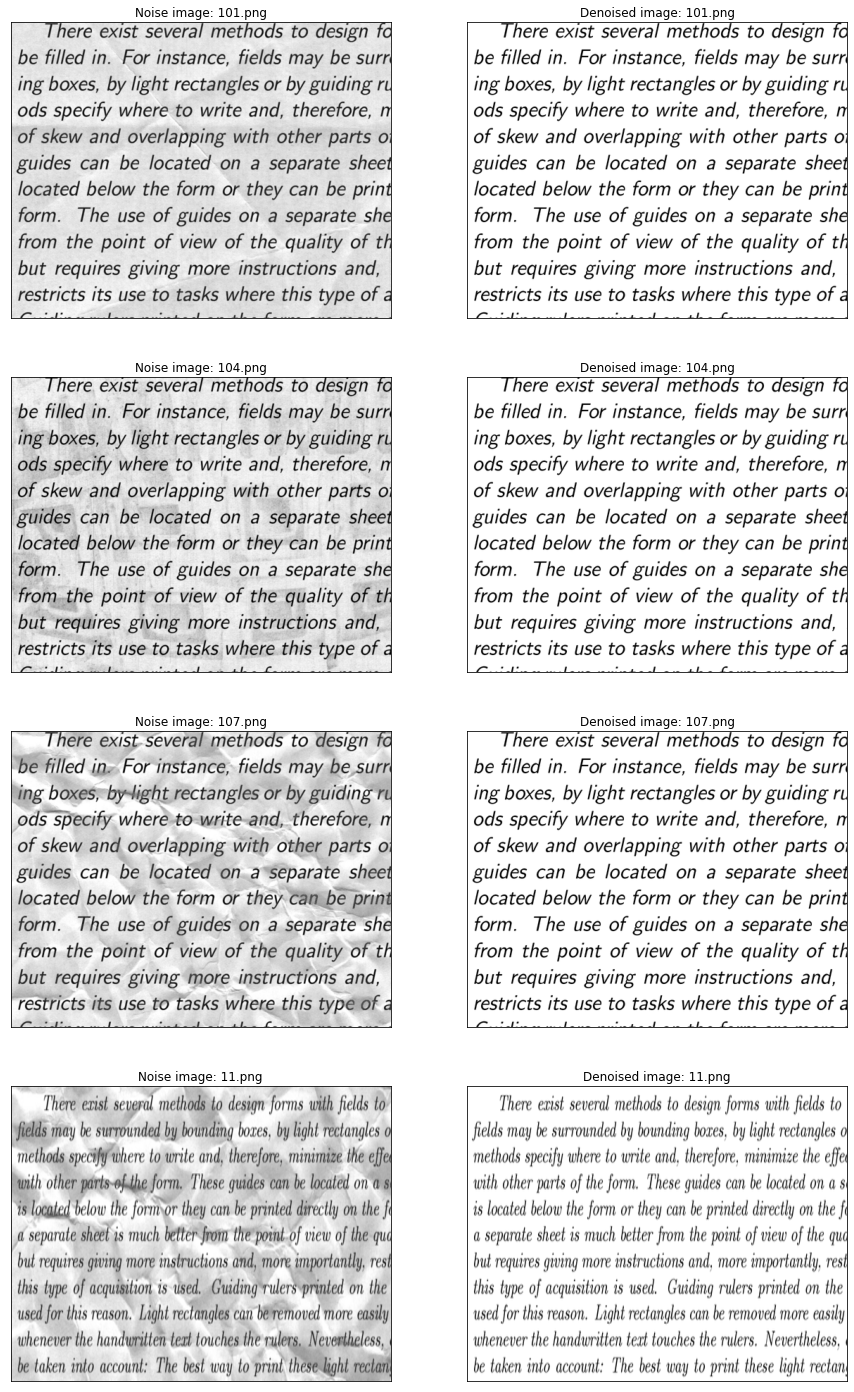

In [9]:
plt.figure(figsize=(15,25))
for i in range(0,8,2):
    plt.subplot(4,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(train[i][:,:,0], cmap='gray')
    plt.title('Noise image: {}'.format(train_img[i]))
    
    plt.subplot(4,2,i+2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(train_cleaned[i][:,:,0], cmap='gray')
    plt.title('Denoised image: {}'.format(train_img[i]))

plt.show()

In [10]:
X_train = np.asarray(train)
Y_train = np.asarray(train_cleaned)
X_test = np.asarray(test)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.15)

In [11]:
from tensorflow import keras
model = keras.Sequential()
#Encoding
model.add(Conv2D(64,(3,3),activation='relu', padding='same',input_shape=(420,540,1)))
model.add(MaxPooling2D((2,2),padding='same'))
#Decoding
model.add(Conv2D(64,(3,3),activation='relu',padding='same'))
model.add(UpSampling2D((2,2)))

model.add(Conv2D(1,(3,3), activation='sigmoid', padding='same'))
model.compile(optimizer='Adam', loss='mse')

2022-11-11 03:50:32.454970: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-11 03:50:32.563200: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-11 03:50:32.563996: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-11 03:50:32.565177: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 420, 540, 64)      640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 210, 270, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 210, 270, 64)      36928     
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 420, 540, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 420, 540, 1)       577       
Total params: 38,145
Trainable params: 38,145
Non-trainable params: 0
_________________________________________________________________


In [17]:
history = model.fit(X_train, Y_train, validation_data = (X_val, Y_val), epochs=100, batch_size = 8)

Epoch 1/100
16/16 [==============================] - 1s 82ms/step - loss: 0.0020 - val_loss: 0.0022
Epoch 2/100
16/16 [==============================] - 1s 71ms/step - loss: 0.0020 - val_loss: 0.0022
Epoch 3/100
16/16 [==============================] - 1s 71ms/step - loss: 0.0020 - val_loss: 0.0022
Epoch 4/100
16/16 [==============================] - 1s 71ms/step - loss: 0.0020 - val_loss: 0.0023
Epoch 5/100
16/16 [==============================] - 1s 72ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 6/100
16/16 [==============================] - 1s 71ms/step - loss: 0.0019 - val_loss: 0.0023
Epoch 7/100
16/16 [==============================] - 1s 71ms/step - loss: 0.0020 - val_loss: 0.0021
Epoch 8/100
16/16 [==============================] - 1s 70ms/step - loss: 0.0019 - val_loss: 0.0021
Epoch 9/100
16/16 [==============================] - 1s 71ms/step - loss: 0.0020 - val_loss: 0.0022
Epoch 10/100
16/16 [==============================] - 1s 75ms/step - loss: 0.0021 - val_loss: 0.0022

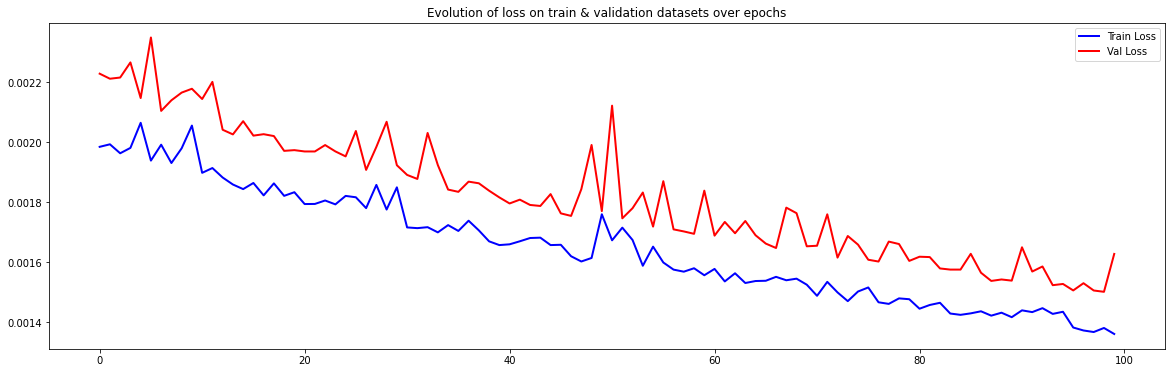

In [18]:
epoch_loss = history.history['loss']
epoch_val_loss = history.history['val_loss']

plt.figure(figsize=(20,6))
plt.plot(range(0,len(epoch_loss)), epoch_loss, 'b-', linewidth=2, label='Train Loss')
plt.plot(range(0,len(epoch_val_loss)), epoch_val_loss, 'r-', linewidth=2, label='Val Loss')
plt.title('Evolution of loss on train & validation datasets over epochs')
plt.legend(loc='best')

plt.show()

In [19]:
Y_test = model.predict(X_test, batch_size=16)

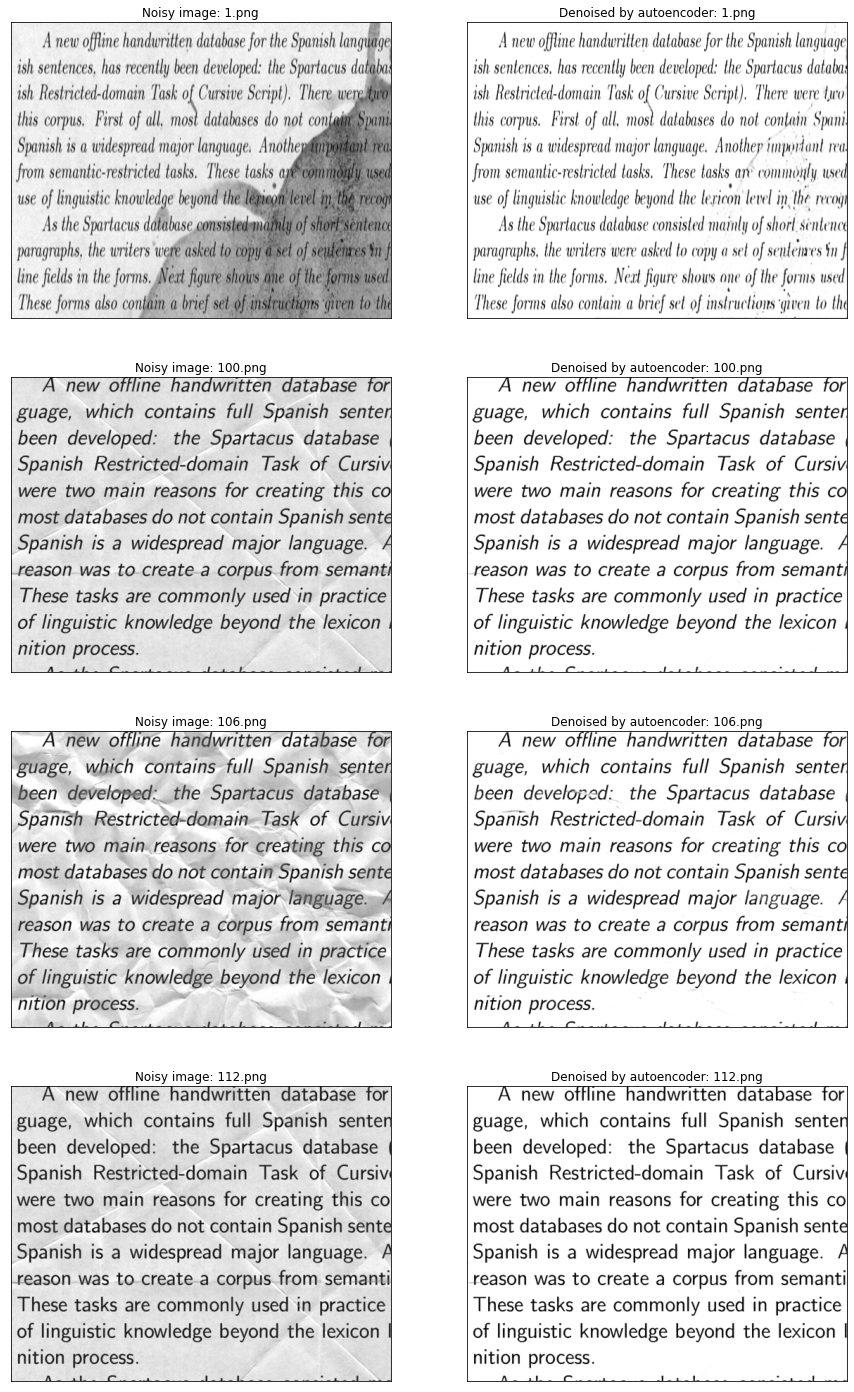

In [20]:
plt.figure(figsize=(15,25))
for i in range(0,8,2):
    plt.subplot(4,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_test[i][:,:,0], cmap='gray')
    plt.title('Noisy image: {}'.format(test_img[i]))
    
    plt.subplot(4,2,i+2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(Y_test[i][:,:,0], cmap='gray')
    plt.title('Denoised by autoencoder: {}'.format(test_img[i]))

plt.show()